In [120]:
import pandas as pd
import geopandas as gpd
import censusdata
import numpy as np

In [121]:
# Downloading Census block boundaries for Chicago
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["GEOID"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
census_group = census_gdf.dissolve(by='GEOID').reset_index()
census_group.crs = "EPSG:4326"
census_group['GEOID'] = census_group['GEOID'].astype(int)

In [122]:
# Housing Assessment Data by Census Block Group
# This dataset was previously merged with block group-level ACS data.
housing = pd.read_csv('data/final_assessments_block_group.csv', sep='\t', index_col=0)
merged = census_group.merge(housing, on ="GEOID", how="inner")
merged.head(2)

,GEOID,geometry,statefp10,name10,blockce10,tract_bloc,geoid10,tractce10,countyfp10,hh_size,...,Roof Material_5.0,Roof Material_6.0,Roof Material_nan,Repair Condition_1.0,Repair Condition_2.0,Repair Condition_3.0,Repair Condition_nan,Renovation_1.0,Renovation_2.0,Renovation_nan
0,170310101001,"POLYGON ((-87.67009 42.02115, -87.67047 42.021...",17,Block 1000,1000,0101001000,170310101001000,010100,031,1.95,...,0.008097,0.0,0.801619,0.004049,0.190283,0.004049,0.801619,0.0,0.0,1.0
1,170310101002,"POLYGON ((-87.66950 42.01936, -87.66963 42.019...",17,Block 2002,2002,0101002002,170310101002002,010100,031,2.26,...,0.006757,0.0,0.817568,0.000000,0.175676,0.006757,0.817568,0.0,0.0,1.0


In [123]:
# Water Quality Data
wdf_g = gpd.read_file('data/water_quality_clean.shp')
wdf_g.crs = "EPSG:4326"
wdf_g.head(2)
wdf_g.columns = ['date', 'address', '1min_draw', '3min_draw', '5min_draw', 
                 'location', 'lat', 'long', 
                 'avg_reading', 'max_reading', 't_high', 't_med', 'geometry']

# Merging datasets
water_acs = gpd.sjoin(wdf_g, merged, how='inner', op='within')

In [124]:
# Creating aggregate dataset
avg_reading = water_acs.groupby('GEOID')['avg_reading'].mean().to_frame('avg_reading_all').reset_index()
max_reading = water_acs.groupby('GEOID')['max_reading'].mean().to_frame('max_reading_all').reset_index()
sample_cnt = water_acs.groupby('GEOID').size().to_frame('sample_cnt').reset_index()

for_plot = census_group.merge(avg_reading, on="GEOID", how="outer")
for_plot = for_plot.merge(max_reading, on="GEOID", how="outer")
for_plot = for_plot.merge(sample_cnt, on="GEOID", how="outer")
for_plot = for_plot.merge(housing, on="GEOID", how="outer")

for_plot['sample_cnt'] = for_plot['sample_cnt'].fillna(0)
for_plot['samp_density'] = for_plot['sample_cnt']/for_plot['tot_pop']
for_plot['samp_density'] = for_plot['samp_density'].replace(np.infty, 0)
for_plot['samp_density'] = for_plot['samp_density'].fillna(0)
for_plot['threshold_high'] = np.where(for_plot['max_reading_all'] >= 15, 1, 0)
for_plot['threshold_medium'] = np.where(for_plot['max_reading_all'] >= 5, 1, 0)

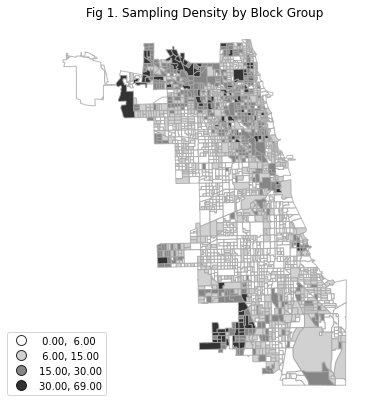

In [125]:
fig = for_plot.plot(column='sample_cnt',
                        cmap = 'Greys',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 1. Sampling Density by Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

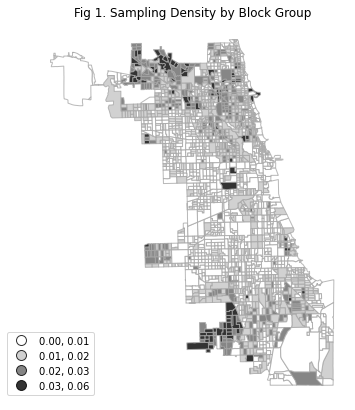

In [126]:
fig = for_plot.plot(column='samp_density',
                        cmap = 'Greys',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 1. Sampling Density by Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

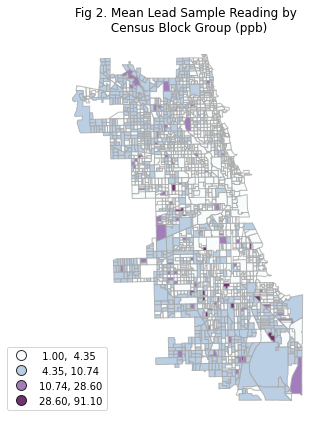

In [127]:
fig = for_plot.plot(column='max_reading_all',
                        cmap = 'BuPu',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 2. Mean Lead Sample Reading by \n Census Block Group (ppb)', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

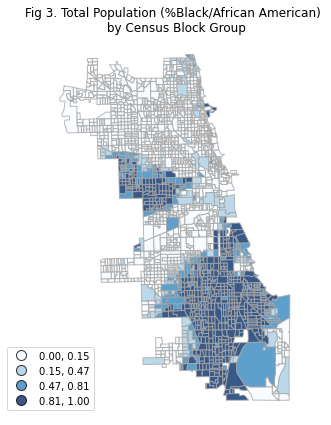

In [128]:
fig = for_plot.plot(column='perc_black',
                        cmap = 'Blues',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 3. Total Population (%Black/African American) \n by Census Block Group', 
              fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

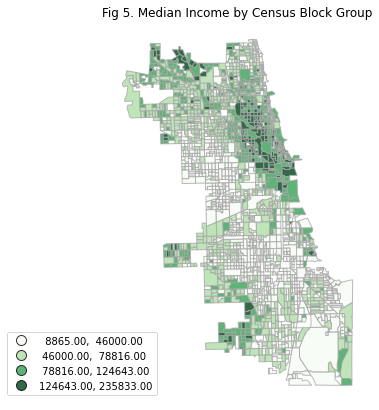

In [129]:
fig = for_plot.plot(column='med_income',
                        cmap = 'Greens',
                        figsize=(11,7),   
                        scheme='natural_breaks', k=4, 
                        legend = True,
                        edgecolor='darkgrey',
                        alpha=0.8)
    
fig.set_title('Fig 5. Median Income by Census Block Group', fontdict= {'fontsize':12})
fig.set_axis_off()
fig.get_legend().set_bbox_to_anchor((0., 0., 0.2, 0.2))

for legend_handle in fig.get_legend().legendHandles:  
    legend_handle._legmarker.set_markeredgewidth(1)
    legend_handle._legmarker.set_markeredgecolor('k')

In [ ]:
# Descriptive Statistics
import seaborn as sns
import matplotlib.pyplot as plt

print("The range for the water quality dataset is:")
print("Max value: {}\nMin value: {}".format(
    max(wdf_g['max_reading']), min(wdf_g['max_reading'])))

# Data is right-skewed
sampl_distrib = sns.boxplot(x="max_reading", data=for_plot)
plt.title('Fig X. Lead Levels (ppb)', fontsize=13) 
plt.xlabel('Lead Level in Sample (ppb)', fontsize=11)
plt.tight_layout()

In [133]:
final_df = for_plot.drop(['geometry', 'statefp10', 'name10', 'blockce10', 'tract_bloc',
       'geoid10', 'tractce10', 'countyfp10', 'samp_density'], axis=1)
final_df.to_csv('data/final_df.csv')

In [ ]:
################################
####### ARCHIVE -- TO DELETE ###

In [ ]:
# Downloading Census block boundaries for Chicago
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
census_group = census_gdf.dissolve(by='geo_12').reset_index()
census_group.crs = "EPSG:4326"

# Pulling ACS data 
census_tables = {
    'GEO_ID': 'GEO_ID', 
    'B02001_001E': 'Race Total', 
    'B02001_002E': 'White', 
    'B02001_003E': 'Black', 
    'B19013_001E': 'Median Income',
    'B03002_002E': 'Not Hispanic'}

acs_df = censusdata.download("acs5", 
                              2018, 
                              censusdata.censusgeo([("state", "17"), 
                                                    ("county", "031"),
                                                    ("tract", "*"),
                                                    ("block group", "*")]), 
                              list(census_tables.keys()))

# Rename columns 
acs_df.rename(columns=census_tables, inplace=True)
acs_df["geo_12"] = acs_df["GEO_ID"].map(lambda x: str(x)[-12:])
merged = census_group.merge(acs_df, on ="geo_12", how="inner")

# Creating new attributes
merged["p_white"] = (merged["White"]/merged["Race Total"])*100
merged["p_black"] = (merged["Black"]/merged["Race Total"])*100
merged["p_hispanic"] = ((merged['Race Total']-merged['Not Hispanic'])/merged["Race Total"])*100

merged.rename(mapper={'Median Income':'med_income'}, axis='columns', inplace=True)
merged["med_income"].replace({-666666666.0: merged["med_income"].median()}, inplace=True)